In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
warnings.filterwarnings("ignore")
# download lexicon for analyzer
nltk.downloader.download('vader_lexicon')
# pass the processed data to the sentiment intensity analyzer 
vader = SentimentIntensityAnalyzer() # initiate the analyzer

In C:\Users\abdul\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\abdul\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\abdul\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\abdul\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\abdul\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [5]:
website = 'https://finviz.com/quote.ashx?t=' # link to news website
news = {} # dictionary to hold the bio tickers news 
tickers = ['AZN','PFE','AAPL','NVDA','MSFT','TSLA','JPM','BA','WMT','DIS'] # list of tickers to analyze
for ticker in tickers:
    url = website + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # save the content of the html webpage
    html = BeautifulSoup(response)
    # now we need to find the table with the id=news-table from the html page inside the table 
    news_table = html.find(id='news-table')
    # save the table in the news dictionary 
    news[ticker] = news_table
#news  
# data preprocessing. 
Processed_news = []
for file_name, news_table in news.items():
    # Iterate through all <tr>
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # cuz some of the columns only consists of time 
        if len(date_scrape) == 1:
            time = date_scrape[0]           
        # date and time correct format  
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name 
        ticker = file_name.split('_')[0]       
        # Append ticker, date, time and headline 
        Processed_news.append([ticker, date, time, text])        
#Processed_news   

In [65]:
# New words and values to help the NLP analyzer catch news about stock better
bio_new_words = {
'lifting':5,
'contract':5,
'treatment':5,
'darpa':5,
'receives':5,
'higher':5,
'competition':-5,
'federal':5,
'jumping':5,
'efficient':5,
'shorted':-5,
'away':-5,
'fda':5,
'nod':5,
'spike':5,
'releases':5,
'preclinical':5,
'sti-1499':5,
'sti-2020':5,
'identifies':5,
'running':-5,
'showcase':5,
'jumped':5,
'pipeline':5,
'adds':5,
'risky':-5,
'riskly':-5,   
'spike':5, 
'covi=drops':5, 
'plummeted':-5,
'surging':5,
'identifies':5,
'ultra-risky':-5,
'files':5,
'eua':5,
'recover':5,
'Stumble':-5,
'recovers':5,
'restrictions':-2,
'beat':5,    
'beats':5         
 }
# Update the lexicon
vader.lexicon.update(bio_new_words)
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame 
news_df = pd.DataFrame(Processed_news, columns=columns)

# get the score for each news
scores = news_df['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
# Join the DataFrames
news_df = news_df.join(scores_df, rsuffix='_right')
# Convert the date column from string to datetime
news_df['date'] = pd.to_datetime(news_df.date).dt.date


start_date = startdate = pd.to_datetime("2020-11-25").date()
end_date = pd.to_datetime("2020-12-02").date()
mask = (news_df['date'] >= start_date) & (news_df['date'] <= end_date)
news_df = news_df.loc[mask]
news_df

# save the data to csv file 
news_df.to_csv("news_analysis.csv", encoding='utf-8', index=False)

In [66]:
news_df

,ticker,date,time,headline,neg,neu,pos,compound
0,AZN,2020-12-02,03:06PM,AstraZeneca U.S. COVID-19 vaccine trial result...,0.000,1.000,0.000,0.0000
1,AZN,2020-12-02,03:04PM,What we still dont know about COVID vaccines a...,0.000,1.000,0.000,0.0000
2,AZN,2020-12-02,02:35PM,Coronavirus update: OWS official says '100% no...,0.123,0.502,0.375,0.7603
3,AZN,2020-12-02,02:28PM,The fight against COVID-19 is not over once th...,0.167,0.833,0.000,-0.3818
4,AZN,2020-12-02,01:15PM,Boris Johnson warns of immense logistical chal...,0.084,0.838,0.078,-0.0258
...,...,...,...,...,...,...,...,...
940,DIS,2020-11-25,09:30AM,"Got $1,000? Here's Why You Should Buy Shares o...",0.000,0.804,0.196,0.2960
941,DIS,2020-11-25,08:39AM,Colin Kaepernick will not play in the NFL agai...,0.169,0.831,0.000,-0.2584
942,DIS,2020-11-25,08:00AM,Dow Hits 30K for First Time: 7 Stocks Driving ...,0.000,1.000,0.000,0.0000
943,DIS,2020-11-25,07:31AM,Will Disney+ Remain a Streaming Superstar?,0.000,1.000,0.000,0.0000


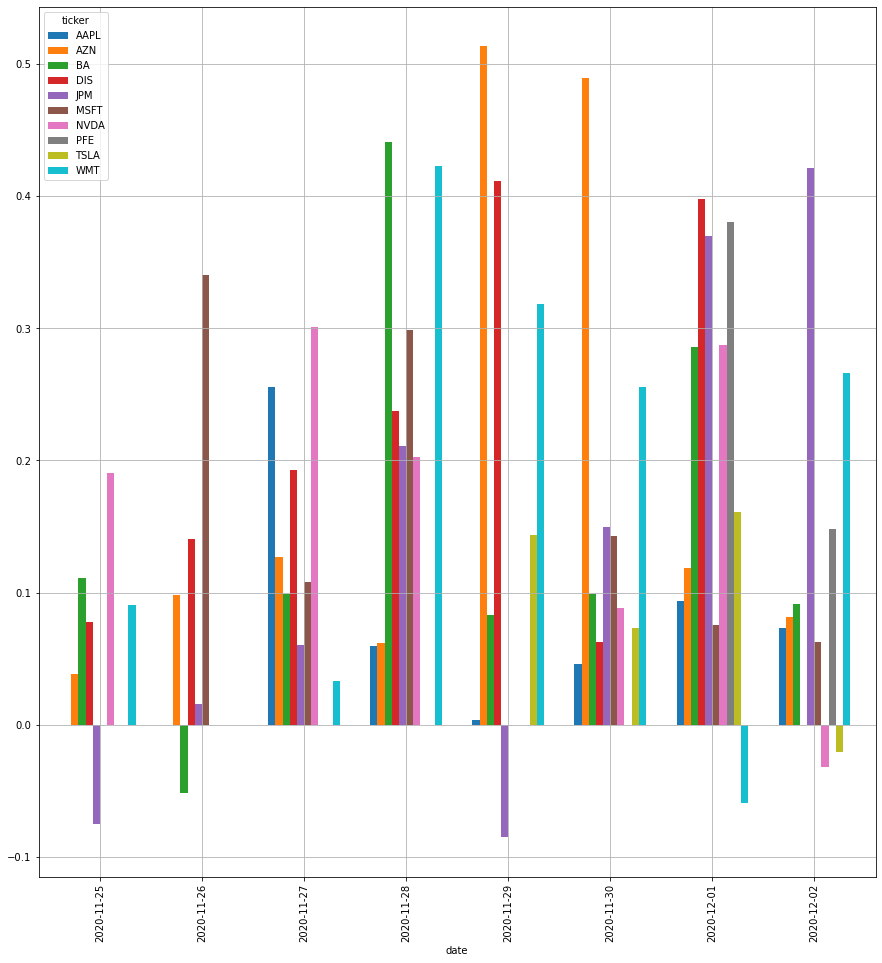

In [86]:
#plot before extracting weekends 
plt.rcParams['figure.figsize'] = [15, 16]
mean_scores = news_df.groupby(['ticker','date']).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot 
mean_scores.plot(kind = 'bar',width=0.7)
plt.grid()
plt.savefig('before.pdf')

In [58]:
AZN = news_df.loc[news_df['ticker'] == "AZN"]
PFE = news_df.loc[news_df['ticker'] == "PFE"]
AAPL = news_df.loc[news_df['ticker'] == "AAPL"]
NVDA = news_df.loc[news_df['ticker'] == "NVDA"]
MSFT = news_df.loc[news_df['ticker'] == "MSFT"]
TSLA = news_df.loc[news_df['ticker'] == "TSLA"]
JPM = news_df.loc[news_df['ticker'] == "JPM"]
BA = news_df.loc[news_df['ticker'] == "BA"]
WMT = news_df.loc[news_df['ticker'] == "WMT"]
DIS = news_df.loc[news_df['ticker'] == "DIS"]


In [59]:
 def append_holiday_values(ticker):
    ticker_processed = ticker[['date', 'compound']]
    ticker_processed.columns = ['date', 'news_value']
    ticker_processed['WEEKDAY'] = pd.to_datetime(ticker_processed['date']).dt.dayofweek  # monday = 0, sunday = 6
    for row in ticker_processed.itertuples(index=True, name='Pandas'):  
        if  row.WEEKDAY == 5 or row.WEEKDAY == 6 :# get saturdays and sundays 
            if row.Index==99: # end of dataframe
                pass
            else:
                if ticker_processed.iloc[row.Index, ticker_processed.columns.get_loc('news_value')]==0:
                    pass
                else:
                    ticker_processed.iloc[row.Index+1,ticker_processed.columns.get_loc('news_value')]=\
                    ticker_processed.iloc[row.Index+1,ticker_processed.columns.get_loc('news_value')]+\
                    ticker_processed.iloc[row.Index,ticker_processed.columns.get_loc('news_value')]
                    ticker_processed.iloc[row.Index,ticker_processed.columns.get_loc('news_value')]=0  
    ticker_processed = ticker_processed[ticker_processed.WEEKDAY != 6]
    ticker_processed = ticker_processed[ticker_processed.WEEKDAY != 5]             
    return ticker_processed


In [61]:
# reindex all tickers
AZN = AZN.reset_index(drop=True)
PFE = PFE.reset_index(drop=True)
AAPL = AAPL.reset_index(drop=True)
NVDA = NVDA.reset_index(drop=True)
MSFT = MSFT.reset_index(drop=True)
TSLA = TSLA.reset_index(drop=True)
JPM = JPM.reset_index(drop=True)
BA = BA.reset_index(drop=True)
WMT = WMT.reset_index(drop=True)
DIS = DIS.reset_index(drop=True)

In [75]:
# remove weekends and append their values to next working day 
AZN_processed = append_holiday_values(AZN)
# make sure no weekends remain if the final news coming happen to be on weekend 
AZN_processed = AZN_processed[AZN_processed.WEEKDAY != 6]
AZN_processed = AZN_processed[AZN_processed.WEEKDAY != 5]
AZN_processed['ticker']='AZN'

# remove weekends and append their values to next working day 
PFE_processed = append_holiday_values(PFE)
# make sure no weekends remain if the final news coming happen to be on weekend 
PFE_processed = PFE_processed[PFE_processed.WEEKDAY != 6]
PFE_processed = PFE_processed[PFE_processed.WEEKDAY != 5]
PFE_processed['ticker']='PFE'

# remove weekends and append their values to next working day 
AAPL_processed = append_holiday_values(AAPL)
# make sure no weekends remain if the final news coming happen to be on weekend 
AAPL_processed = AAPL_processed[AAPL_processed.WEEKDAY != 6]
AAPL_processed = AAPL_processed[AAPL_processed.WEEKDAY != 5]
AAPL_processed['ticker']='AAPL'

# remove weekends and append their values to next working day 
NVDA_processed = append_holiday_values(NVDA)
# make sure no weekends remain if the final news coming happen to be on weekend 
NVDA_processed = NVDA_processed[NVDA_processed.WEEKDAY != 6]
NVDA_processed = NVDA_processed[NVDA_processed.WEEKDAY != 5]
NVDA_processed['ticker']='NVDA'

# remove weekends and append their values to next working day 
MSFT_processed = append_holiday_values(MSFT)
# make sure no weekends remain if the final news coming happen to be on weekend 
MSFT_processed = MSFT_processed[MSFT_processed.WEEKDAY != 6]
MSFT_processed = MSFT_processed[MSFT_processed.WEEKDAY != 5]
MSFT_processed['ticker']='MSFT'

# remove weekends and append their values to next working day 
TSLA_processed = append_holiday_values(TSLA)
# make sure no weekends remain if the final news coming happen to be on weekend 
TSLA_processed = TSLA_processed[TSLA_processed.WEEKDAY != 6]
TSLA_processed = TSLA_processed[TSLA_processed.WEEKDAY != 5]
TSLA_processed['ticker']='TSLA'

# remove weekends and append their values to next working day 
JPM_processed = append_holiday_values(JPM)
# make sure no weekends remain if the final news coming happen to be on weekend 
JPM_processed = JPM_processed[JPM_processed.WEEKDAY != 6]
JPM_processed = JPM_processed[JPM_processed.WEEKDAY != 5]
JPM_processed['ticker']='JPM'

# remove weekends and append their values to next working day 
BA_processed = append_holiday_values(BA)
# make sure no weekends remain if the final news coming happen to be on weekend 
BA_processed = BA_processed[BA_processed.WEEKDAY != 6]
BA_processed = BA_processed[BA_processed.WEEKDAY != 5]
BA_processed['ticker']='BA'

# remove weekends and append their values to next working day 
WMT_processed = append_holiday_values(WMT)
# make sure no weekends remain if the final news coming happen to be on weekend 
WMT_processed = WMT_processed[WMT_processed.WEEKDAY != 6]
WMT_processed = WMT_processed[WMT_processed.WEEKDAY != 5]
WMT_processed['ticker']='WMT'

# remove weekends and append their values to next working day 
DIS_processed = append_holiday_values(DIS)
# make sure no weekends remain if the final news coming happen to be on weekend 
DIS_processed = DIS_processed[DIS_processed.WEEKDAY != 6]
DIS_processed = DIS_processed[DIS_processed.WEEKDAY != 5]
DIS_processed['ticker']='DIS'

In [79]:
news_df_after = pd.concat([AZN_processed, PFE_processed,AAPL_processed,NVDA_processed,MSFT_processed,TSLA_processed\
                           ,JPM_processed,BA_processed,WMT_processed,DIS_processed])
del news_df_after['WEEKDAY']

In [80]:
news_df_after

,date,news_value,ticker
0,2020-12-02,0.0000,AZN
1,2020-12-02,0.0000,AZN
2,2020-12-02,0.7603,AZN
3,2020-12-02,-0.3818,AZN
4,2020-12-02,-0.0258,AZN
...,...,...,...
40,2020-11-25,0.2960,DIS
41,2020-11-25,-0.2584,DIS
42,2020-11-25,0.0000,DIS
43,2020-11-25,0.0000,DIS


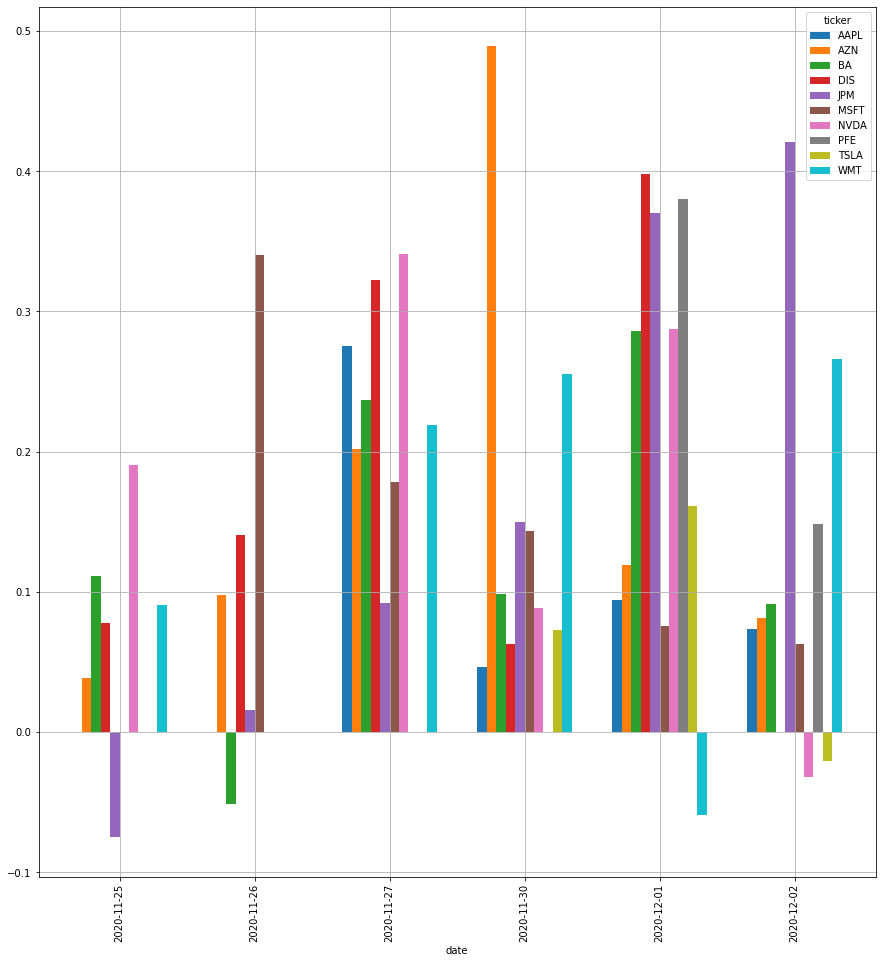

In [85]:
#plot after extracting weekends 
plt.rcParams['figure.figsize'] = [15, 16]
mean_scores1 = news_df_after.groupby(['ticker','date']).mean()
mean_scores1 = mean_scores1.unstack()
mean_scores1 = mean_scores1.xs('news_value', axis="columns").transpose()
# Plot 
mean_scores1.plot(kind = 'bar',width=0.7)
plt.grid()
plt.savefig('after.pdf')

In [83]:
# save the data to csv file 
news_df_after.to_csv("news_analysis_processed.csv", encoding='utf-8', index=False)